In [ ]:
from feature_engineering_final import HDFSFeatureEngineering
from isolation_forest_final import IsolationForestDetector
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2025-11-06 13:31:21.530149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



PREPARING TRADITIONAL ML FEATURES

Step 1: Extracting event count features...
✓ Event count features: 29 features

Step 2: Computing sequence statistics...
✓ Sequence statistics: 3 features

Step 3: Extracting temporal features...
✓ Temporal features: 2 features

Step 4: Computing error features...
✓ Error features: 3 features

✓ Total features: 37
✓ Total samples: 575061
✓ Anomaly rate: 2.93%

TRAINING ISOLATION FOREST (Unsupervised)

Contamination: 0.03
Training samples: 460048
Features: 37

Scaling features...
Training Isolation Forest...
✓ Training complete!

EVALUATING ISOLATION FOREST

--- Classification Report ---
              precision    recall  f1-score   support

      Normal     0.9878    0.9876    0.9877    111664
     Anomaly     0.5887    0.5924    0.5906      3349

    accuracy                         0.9761    115013
   macro avg     0.7882    0.7900    0.7891    115013
weighted avg     0.9762    0.9761    0.9761    115013


--- Confusion Matrix ---
True Negatives:  

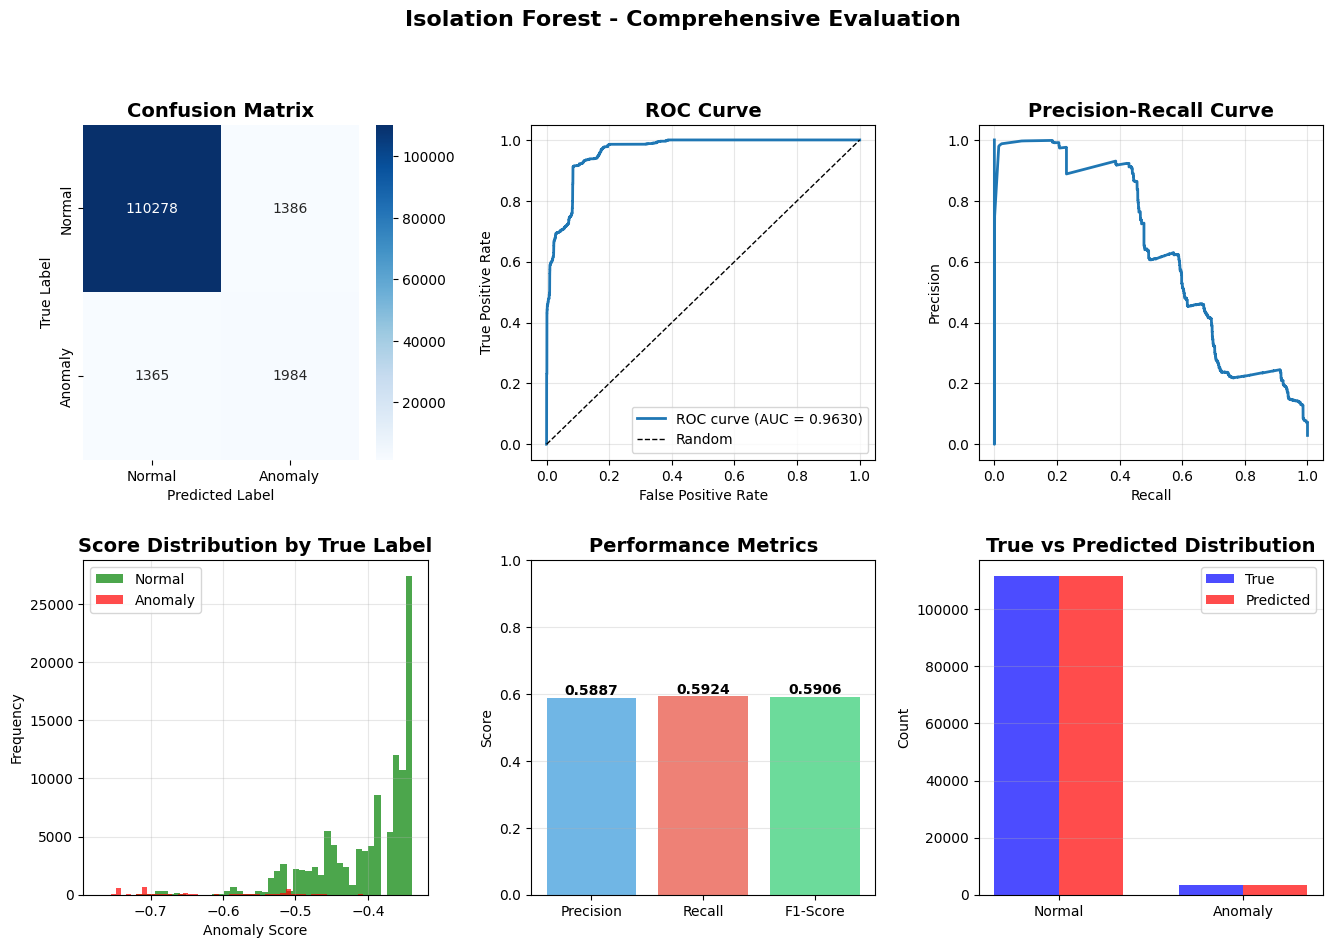

In [2]:
# load data
event_traces_df = pd.read_csv("preprocessed/Event_traces.csv")
event_matrix_df = pd.read_csv("preprocessed/Event_occurrence_matrix.csv")

# Feature engineering
fe = HDFSFeatureEngineering()
X, y, names = fe.prepare_features_for_traditional_ml(event_matrix_df, event_traces_df)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate
detector = IsolationForestDetector(contamination=0.03)
detector.train(X_train_scaled)
results = detector.evaluate(X_test_scaled, y_test)

In [ ]:
# --- Autoencoder Only ---
from autoencoder_final import AutoencoderDetector

# Feature engineering
X_seq, y_seq = fe.prepare_sequences_for_deep_learning(event_traces_df)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Normalize
X_train_norm = X_train / fe.get_vocab_size()
X_val_norm = X_val / fe.get_vocab_size()
X_test_norm = X_test / fe.get_vocab_size()

# Build, train, evaluate
detector = AutoencoderDetector(input_dim=X_train_norm.shape[1], encoding_dim=32)
detector.build_model()
detector.train(X_train_norm, X_val_norm, epochs=100)
detector.compute_threshold(X_train_norm, percentile=95)
results = detector.evaluate(X_test_norm, y_test)


PREPARING SEQUENTIAL FEATURES (Deep Learning)

Step 1: Building event vocabulary...
